In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchsummary import summary

In [3]:
# using GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
# ensuring reproducibility of code
torch.manual_seed(0)
np.random.seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
# loading data

batch_size = 256

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


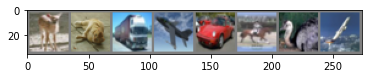

deer cat truck plane car horse bird plane


In [6]:
def imshow(img):
    """
    function to plot images.
    """
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
images = images[0:8]

# show images
imshow(torchvision.utils.make_grid(images))
print(' '.join('%s' % classes[labels[j]] for j in range(8)))

In [7]:
class VGGlike(nn.Module):
    """
    returns VGG-like neural network architecture.
    """
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size = 3, padding = 1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size = 3, padding = 1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size = 3, padding = 1)
        self.conv5 = nn.Conv2d(128, 256, kernel_size = 3, padding = 1)
        self.conv6 = nn.Conv2d(256, 256, kernel_size = 3, padding = 1)
        self.conv7 = nn.Conv2d(256, 512, kernel_size = 3, padding = 1)
        self.conv8 = nn.Conv2d(512, 512, kernel_size = 3, padding = 1)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn4 = nn.BatchNorm2d(512)
        self.bn5 = nn.BatchNorm1d(1024)
        self.bn6 = nn.BatchNorm1d(256)
        self.pool = nn.MaxPool2d(2)
        self.dropout1 = nn.Dropout(p = 0.50)
        self.dropout2 = nn.Dropout(p = 0.60)
        self.fc1 = nn.Linear(2 * 2 * 512, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.dropout1(F.relu(self.conv2(x)))
        x = self.pool(x)
        x = F.relu(self.bn2(self.conv3(x)))
        x = self.dropout1(F.relu(self.conv4(x)))
        x = self.pool(x)
        x = F.relu(self.bn3(self.conv5(x)))
        x = F.relu(self.bn3(self.conv6(x)))
        x = self.dropout1(F.relu(self.conv6(x)))
        x = self.pool(x)
        x = F.relu(self.bn4(self.conv7(x)))
        x = F.relu(self.bn4(self.conv8(x)))
        x = self.dropout1(F.relu(self.conv8(x)))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.dropout2(F.relu(self.bn5(self.fc1(x))))
        x = self.dropout2(F.relu(self.bn6(self.fc2(x))))
        x = self.fc3(x)
        return x

In [8]:
# moving net to GPU
net = VGGlike()
net.to(device)
summary(net, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
            Conv2d-3           [-1, 64, 32, 32]          18,496
           Dropout-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          73,856
       BatchNorm2d-7          [-1, 128, 16, 16]             256
            Conv2d-8          [-1, 128, 16, 16]         147,584
           Dropout-9          [-1, 128, 16, 16]               0
        MaxPool2d-10            [-1, 128, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]         295,168
      BatchNorm2d-12            [-1, 256, 8, 8]             512
           Conv2d-13            [-1, 256, 8, 8]         590,080
      BatchNorm2d-14            [-1, 25

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [ ]:
# defining loss, optimizer and lr scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(net.parameters(), lr = 2e-3, weight_decay = 1e-4)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, [35, 45])

In [ ]:
# training loop

for epoch in range(50):  # loop over the dataset multiple times
    running_loss = 0.0
    total = 0
    correct = 0

    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # keep track of loss and accuracy
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    scheduler.step()

    # print statistics
    accuracy = 100 * (correct / total)
    print("Epoch", epoch + 1)
    print(f'  Accuracy of the network on the {total} training images: {accuracy}')
    print(f'  Loss of the network on the {total} training images: {running_loss}')

print('Finished Training')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 1
  Accuracy of the network on the 50000 training images: 29.724
  Loss of the network on the 50000 training images: 355.6068196296692
Epoch 2
  Accuracy of the network on the 50000 training images: 50.83
  Loss of the network on the 50000 training images: 259.1981500387192
Epoch 3
  Accuracy of the network on the 50000 training images: 62.82
  Loss of the network on the 50000 training images: 205.77367079257965
Epoch 4
  Accuracy of the network on the 50000 training images: 69.262
  Loss of the network on the 50000 training images: 172.97904878854752
Epoch 5
  Accuracy of the network on the 50000 training images: 73.832
  Loss of the network on the 50000 training images: 149.4962279200554
Epoch 6
  Accuracy of the network on the 50000 training images: 77.224
  Loss of the network on the 50000 training images: 132.43245840072632
Epoch 7
  Accuracy of the network on the 50000 training images: 79.724
  Loss of the network on the 50000 training images: 118.73048132658005
Epoch 8
  A

In [ ]:
# saving weights of model
model_save_name = 'cifarvgglike.pt'
path = f"/content/gdrive/My Drive/Deep Learning/pytorch-experiments/Vision/{model_save_name}" 
torch.save(net.state_dict(), path)

In [ ]:
# loading model
model_save_name = 'cifarvgglike.pt'
PATH = f"/content/gdrive/My Drive/Deep Learning/pytorch-experiments/Vision/{model_save_name}"
model_state_dict = torch.load(PATH)
model = VGGlike()
model.load_state_dict(model_state_dict)
model.to(device)

<All keys matched successfully>

In [ ]:
# evaluating on test set
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the {total} test images: {100 * correct / total}')

Accuracy of the network on the 10000 test images: 87.66
